# Heat Pump Flexibility

This tutorial covers heat pump modeling and flexibility mechanisms in PyPSA-GB, including demand disaggregation, thermal storage, and demand shifting.

## What You'll Learn

- How heat pump electricity demand is calculated from FES data
- The two space heating flexibility mechanisms: TANK and COSY
- How COP (Coefficient of Performance) varies with temperature
- How to analyze heat pump flexibility results
- PyPSA components created for heat flexibility

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Understanding Heat Pump Flexibility

### 2.1 Why Heat Pump Flexibility Matters

Heat pumps are a key technology for decarbonizing heating in Great Britain. They convert electricity into heat at high efficiency (COP 2-5 depending on temperature), but they add significant new electricity demand. By 2035, FES projects that heat pumps could add 20-40 TWh of electricity demand.

**Flexibility** allows this demand to be shifted in time, helping to:
- Reduce peak demand on the electricity grid
- Better utilize renewable generation when it's available
- Reduce consumer energy costs by heating at off-peak times

### 2.2 Two Space Heating Flexibility Mechanisms

PyPSA-GB models two complementary flexibility mechanisms. **Both are for space heating**, but use different physical storage:

| Mechanism | Physical Storage | PyPSA Load Carrier | How It Works | Typical Capacity |
|-----------|------------------|-------------------|--------------|------------------|
| **TANK** | Hot water cylinder | `hot water demand` | Pre-heats water in tank, releases heat when needed | 10-50 kWh thermal |
| **COSY** | Building thermal mass | `space heating` | Pre-heats building fabric (walls, floors), slowly releases heat | 2-10 kWh/100m² |

#### TANK Mode (Hot Water Tank Storage)
```
                    COP
Electricity ──▶ [Heat Pump] ──▶ [Hot Water Tank] ──▶ Space Heating
    (MW)         (Link)           (Store)              (Load)
```
- Heat pump converts electricity to heat at COP efficiency
- Heat stored in insulated hot water tank (can be charged/discharged)
- Tank releases heat to space heating system when needed
- Heat loss: ~1-3% per hour depending on insulation

#### COSY Mode (Building Thermal Inertia)
```
                    COP
Electricity ──▶ [Heat Pump] ──▶ [Building Mass] ──▶ Space Heating
    (MW)         (Link)           (Store)             (Load)
```
- Heat pump converts electricity to heat at COP efficiency
- Heat absorbed by building fabric (concrete, brick, furniture)
- Building slowly releases stored heat, maintaining comfort
- Heat loss depends on building insulation (EPC rating)


## 3. Load a Network with Heat Pump Flexibility

In [2]:
# Load a solved network with heat pump flexibility enabled
# HT35_flex is a future scenario (2035, Holistic Transition) with heat flexibility
n = pypsa.Network("../../../resources/network/HT35_flex_solved.nc")

print("Network loaded")
print(f"  Buses: {len(n.buses)}")
print(f"  Loads: {len(n.loads)}")
print(f"  Links: {len(n.links)}")
print(f"  Stores: {len(n.stores)}")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"  Period: {n.snapshots[0]} to {n.snapshots[-1]}")

INFO:pypsa.network.io:Imported network 'HT35_flex (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Buses: 924
  Loads: 877
  Links: 1221
  Stores: 627
  Snapshots: 168
  Period: 2035-01-13 00:00:00 to 2035-01-19 23:00:00


## 4. Heat Pump Components in the Network

### 4.1 Identifying Heat Pump Loads

In [3]:
# Heat pump loads are identified by their carrier, not by naming convention
# TANK mode (hot water demand)
tank_loads = n.loads[n.loads['carrier'] == 'hot water demand']
print(f"TANK mode loads (hot water demand): {len(tank_loads)}")

# COSY mode (space heating)
cosy_loads = n.loads[n.loads['carrier'] == 'space heating']
print(f"COSY mode loads (space heating): {len(cosy_loads)}")

# Base electricity loads (non-flexible)
base_loads = n.loads[n.loads['carrier'] == '']
print(f"Base electricity loads (non-flexible): {len(base_loads)}")

# Total heat pump loads
total_hp_loads = len(tank_loads) + len(cosy_loads)
print(f"\nTotal heat pump loads: {total_hp_loads}")

# Show sample loads from each type
if len(tank_loads) > 0:
    print("\nSample TANK loads (hot water demand):")
    print(tank_loads[['bus', 'carrier']].head())

if len(cosy_loads) > 0:
    print("\nSample COSY loads (space heating):")
    print(cosy_loads[['bus', 'carrier']].head())


TANK mode loads (hot water demand): 313
COSY mode loads (space heating): 313
Base electricity loads (non-flexible): 0

Total heat pump loads: 626

Sample TANK loads (hot water demand):
                                           bus           carrier
name                                                            
ABHA11 hot water demand tank  heat_ABHA11 heat  hot water demand
ABNE3- hot water demand tank  heat_ABNE3- heat  hot water demand
ABTH11 hot water demand tank  heat_ABTH11 heat  hot water demand
ALNE3J hot water demand tank  heat_ALNE3J heat  hot water demand
ALST31 hot water demand tank  heat_ALST31 heat  hot water demand

Sample COSY loads (space heating):
                                                         bus        carrier
name                                                                       
ABHA11 space heating  thermal inertia_ABHA11 thermal inertia  space heating
ABNE3- space heating  thermal inertia_ABNE3- thermal inertia  space heating
ABTH11 space heating

### 4.2 Heat Pump Links (Electric → Thermal Conversion)

In [4]:
# First, let's see what links actually exist in the network
print("Link Carriers in Network:")
print(n.links['carrier'].value_counts())
print("\n" + "="*60)

print("\nSample Link Names (first 20):")
print(n.links.index[:20].tolist())
print("\n" + "="*60)

print("\nLinks containing 'hp' in name:")
hp_related = [l for l in n.links.index if 'hp' in l.lower()]
print(f"Found {len(hp_related)} links with 'hp' in name")
if hp_related:
    print(hp_related[:20])

print("\n" + "="*60)
print("\nLinks with 'heat pump' in name:")
heat_pump_links = [l for l in n.links.index if 'heat pump' in l.lower()]
print(f"Found {len(heat_pump_links)} links with 'heat pump' in name")
if heat_pump_links:
    print(heat_pump_links[:20])


Link Carriers in Network:
carrier
heat pump         626
thermal demand    313
H2_turbine        242
electrolysis       24
DC                 13
AC                  3
Name: count, dtype: int64


Sample Link Names (first 20):
['2954', '2955', '2956', 'CLAC1Q heat pump tank', 'CRAR1R heat pump tank', 'DUNO1Q heat pump tank', 'DUNO1R heat pump tank', 'KEIT3- heat pump tank', 'QUOI1- heat pump tank', 'RANN1Q heat pump tank', 'RANN1R heat pump tank', 'SFEG1S heat pump tank', 'CURR1A heat pump tank', 'CURR1B heat pump tank', 'HUCS4- heat pump tank', 'HUER1- heat pump tank', 'REDH1- heat pump tank', 'IROA11 heat pump tank', 'STEN11 heat pump tank', 'USKM11 heat pump tank']


Links containing 'hp' in name:
Found 0 links with 'hp' in name


Links with 'heat pump' in name:
Found 626 links with 'heat pump' in name
['CLAC1Q heat pump tank', 'CRAR1R heat pump tank', 'DUNO1Q heat pump tank', 'DUNO1R heat pump tank', 'KEIT3- heat pump tank', 'QUOI1- heat pump tank', 'RANN1Q heat pump tank', 'RANN1R he

In [5]:
# Links that convert electricity to heat
# TANK mode: 'heat pump' links that charge hot water tanks
tank_hp_links = n.links[(n.links['carrier'] == 'heat pump') & (n.links.index.str.contains('tank'))]
print(f"TANK heat pump links: {len(tank_hp_links)}")

# COSY mode: 'thermal demand' links that deliver heat from building mass
cosy_thermal_links = n.links[n.links['carrier'] == 'thermal demand']
print(f"COSY thermal demand links: {len(cosy_thermal_links)}")

# Total HP links
total_hp_links = len(tank_hp_links) + len(cosy_thermal_links)
print(f"\nTotal heat pump/thermal links: {total_hp_links}")

# Show structure - bus0 is electrical, bus1 is thermal
if len(tank_hp_links) > 0:
    print("\nSample TANK heat pump links:")
    print(tank_hp_links[['bus0', 'bus1', 'p_nom', 'carrier']].head())

if len(cosy_thermal_links) > 0:
    print("\nSample COSY thermal demand links:")
    print(cosy_thermal_links[['bus0', 'bus1', 'p_nom', 'carrier']].head())


TANK heat pump links: 313
COSY thermal demand links: 313

Total heat pump/thermal links: 626

Sample TANK heat pump links:
                                                     bus0              bus1  \
name                                                                          
CLAC1Q heat pump tank                       ARDK_P|CLAC_P  heat_CLAC1Q heat   
CRAR1R heat pump tank                              DUNO_P  heat_CRAR1R heat   
DUNO1Q heat pump tank                              DUNO_P  heat_DUNO1Q heat   
DUNO1R heat pump tank                              DUNO_P  heat_DUNO1R heat   
KEIT3- heat pump tank  BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P  heat_KEIT3- heat   

                          p_nom    carrier  
name                                        
CLAC1Q heat pump tank  0.166714  heat pump  
CRAR1R heat pump tank  0.729680  heat pump  
DUNO1Q heat pump tank  0.174619  heat pump  
DUNO1R heat pump tank  0.174619  heat pump  
KEIT3- heat pump tank  1.251625  heat pump  

Sample 

### 4.3 Thermal Storage (Stores)

In [6]:
# Identify thermal buses and stores
thermal_buses = n.buses[n.buses['carrier'] == 'heat']
print(f"Thermal buses (for heat): {len(thermal_buses)}")

# TANK stores (hot water tanks)
tank_stores = n.stores[n.stores['carrier'] == 'hot water']
print(f"TANK stores (hot water tanks): {len(tank_stores)}")

# COSY stores (building thermal mass)
cosy_stores = n.stores[n.stores['carrier'] == 'thermal inertia']
print(f"COSY stores (building thermal mass): {len(cosy_stores)}")

if len(tank_stores) > 0:
    print(f"\nTotal TANK storage capacity: {tank_stores['e_nom'].sum():.1f} MWh")
    print(f"  Mean per location: {tank_stores['e_nom'].mean():.2f} MWh")
    print(f"  Sample TANK stores:")
    print(tank_stores[['bus', 'carrier', 'e_nom']].head())

if len(cosy_stores) > 0:
    print(f"\nTotal COSY storage capacity: {cosy_stores['e_nom'].sum():.1f} MWh")
    print(f"  Mean per location: {cosy_stores['e_nom'].mean():.2f} MWh")
    print(f"  Sample COSY stores:")
    print(cosy_stores[['bus', 'carrier', 'e_nom']].head())


Thermal buses (for heat): 313
TANK stores (hot water tanks): 313
COSY stores (building thermal mass): 313

Total TANK storage capacity: 1041.1 MWh
  Mean per location: 3.33 MWh
  Sample TANK stores:
                                         bus    carrier     e_nom
name                                                             
CLAC1Q hot water tank tank  heat_CLAC1Q heat  hot water  0.139533
CRAR1R hot water tank tank  heat_CRAR1R heat  hot water  0.620923
DUNO1Q hot water tank tank  heat_DUNO1Q heat  hot water  0.146510
DUNO1R hot water tank tank  heat_DUNO1R heat  hot water  0.146510
KEIT3- hot water tank tank  heat_KEIT3- heat  hot water  1.063942

Total COSY storage capacity: 895.8 MWh
  Mean per location: 2.86 MWh
  Sample COSY stores:
                                                                 bus  \
name                                                                   
CLAC1Q building thermal mass  thermal inertia_CLAC1Q thermal inertia   
CRAR1R building thermal mass  t

## 5. Coefficient of Performance (COP)

### 5.1 Understanding COP

The Coefficient of Performance (COP) determines how efficiently a heat pump converts electricity to heat:

$$\text{Thermal Output (kW)} = \text{Electrical Input (kW)} \times \text{COP}$$

COP varies with temperature:
- **Milder weather** (10°C): COP ~4-5 (very efficient)
- **Cold weather** (0°C): COP ~2-3 (less efficient)
- **Very cold** (-5°C): COP ~1.5-2 (least efficient)

This is why PyPSA-GB uses time-varying COP based on weather data.

COP Statistics for CLAC1Q heat pump tank:
  Mean: 3.94
  Min: 3.80
  Max: 4.07
  Std: 0.07


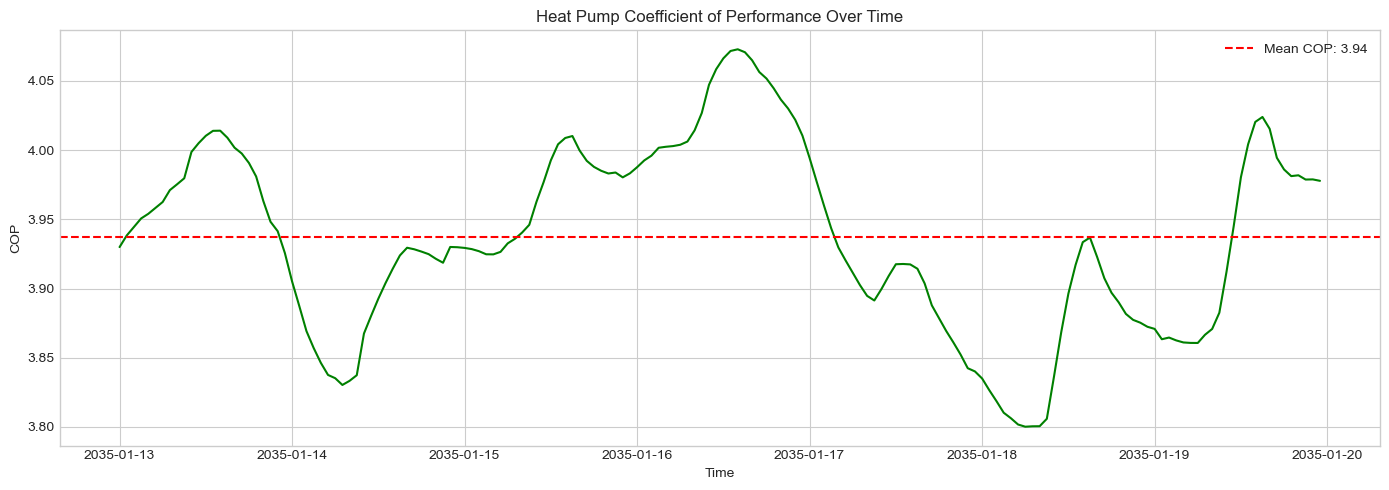

In [7]:
# Check if COP time series exists (stored as link efficiency)
# COP is on the TANK heat pump links
tank_hp_links = n.links[(n.links['carrier'] == 'heat pump') & (n.links.index.str.contains('tank'))]

if len(n.links_t.efficiency) > 0 and len(tank_hp_links) > 0:
    # Get COP for one heat pump link
    sample_link = tank_hp_links.index[0]
    
    if sample_link in n.links_t.efficiency.columns:
        cop_series = n.links_t.efficiency[sample_link]
        
        print(f"COP Statistics for {sample_link}:")
        print(f"  Mean: {cop_series.mean():.2f}")
        print(f"  Min: {cop_series.min():.2f}")
        print(f"  Max: {cop_series.max():.2f}")
        print(f"  Std: {cop_series.std():.2f}")
        
        # Plot COP over time
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(cop_series.index, cop_series.values, linewidth=1.5, color='green')
        ax.axhline(y=cop_series.mean(), color='red', linestyle='--', 
                   label=f'Mean COP: {cop_series.mean():.2f}')
        ax.set_ylabel('COP')
        ax.set_xlabel('Time')
        ax.set_title('Heat Pump Coefficient of Performance Over Time')
        ax.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Note: COP may be stored as static efficiency in links DataFrame")
    if len(tank_hp_links) > 0:
        print(f"Static efficiency values: {tank_hp_links['efficiency'].describe()}")


## 6. Analyzing Flexibility Behavior

### 6.1 Heat Pump Power Consumption

Heat Pump Electricity Consumption (MW):
  Mean: 3274.3
  Peak: 3622.0
  Min: 2747.9

Total HP Energy: 550.1 GWh over 168 hours


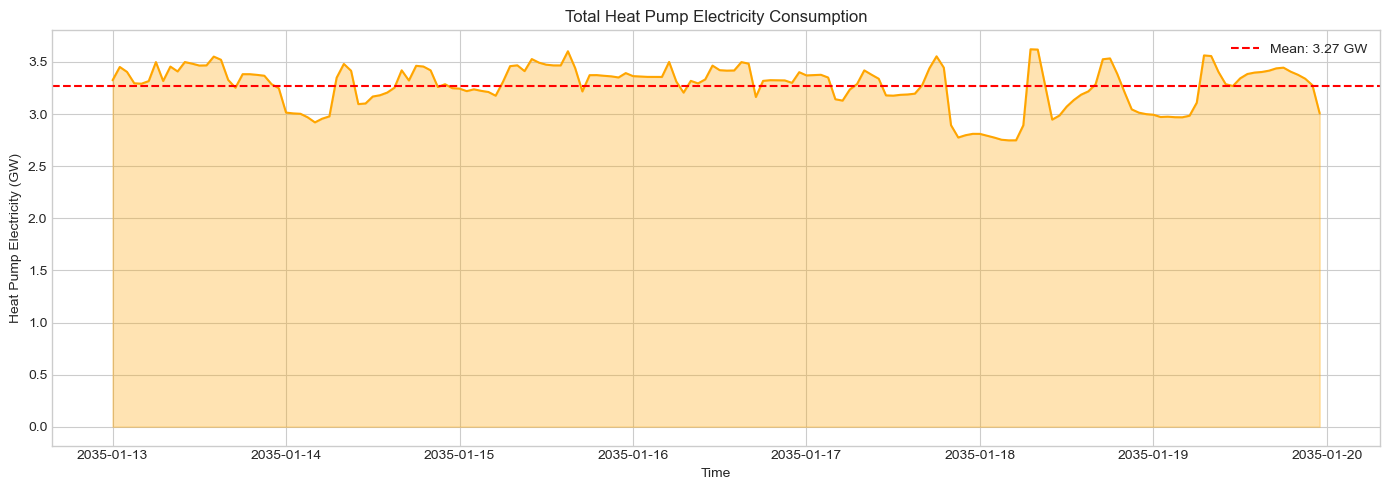

In [8]:
# Get heat pump link power flows (electricity consumption)
# Include both TANK heat pump links and COSY thermal demand links
tank_hp_links = n.links[(n.links['carrier'] == 'heat pump') & (n.links.index.str.contains('tank'))]
cosy_thermal_links = n.links[n.links['carrier'] == 'thermal demand']

if len(n.links_t.p0) > 0 and (len(tank_hp_links) > 0 or len(cosy_thermal_links) > 0):
    tank_link_cols = [c for c in n.links_t.p0.columns if c in tank_hp_links.index]
    cosy_link_cols = [c for c in n.links_t.p0.columns if c in cosy_thermal_links.index]
    hp_link_cols = tank_link_cols + cosy_link_cols
    
    if hp_link_cols:
        # p0 is positive when power flows from bus0 (electrical) to bus1 (thermal)
        hp_power = n.links_t.p0[hp_link_cols].sum(axis=1)  # Total HP electricity consumption
        
        print("Heat Pump Electricity Consumption (MW):")
        print(f"  Mean: {hp_power.mean():.1f}")
        print(f"  Peak: {hp_power.max():.1f}")
        print(f"  Min: {hp_power.min():.1f}")
        
        # Total energy
        hours = len(n.snapshots)
        energy_gwh = hp_power.sum() / 1000
        print(f"\nTotal HP Energy: {energy_gwh:.1f} GWh over {hours} hours")
        
        # Plot
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.plot(hp_power.index, hp_power.values / 1000, linewidth=1.5, color='orange')
        ax.fill_between(hp_power.index, hp_power.values / 1000, alpha=0.3, color='orange')
        ax.axhline(y=hp_power.mean() / 1000, color='red', linestyle='--',
                   label=f'Mean: {hp_power.mean()/1000:.2f} GW')
        ax.set_ylabel('Heat Pump Electricity (GW)')
        ax.set_xlabel('Time')
        ax.set_title('Total Heat Pump Electricity Consumption')
        ax.legend()
        plt.tight_layout()
        plt.show()


### 6.2 Thermal Storage Behavior

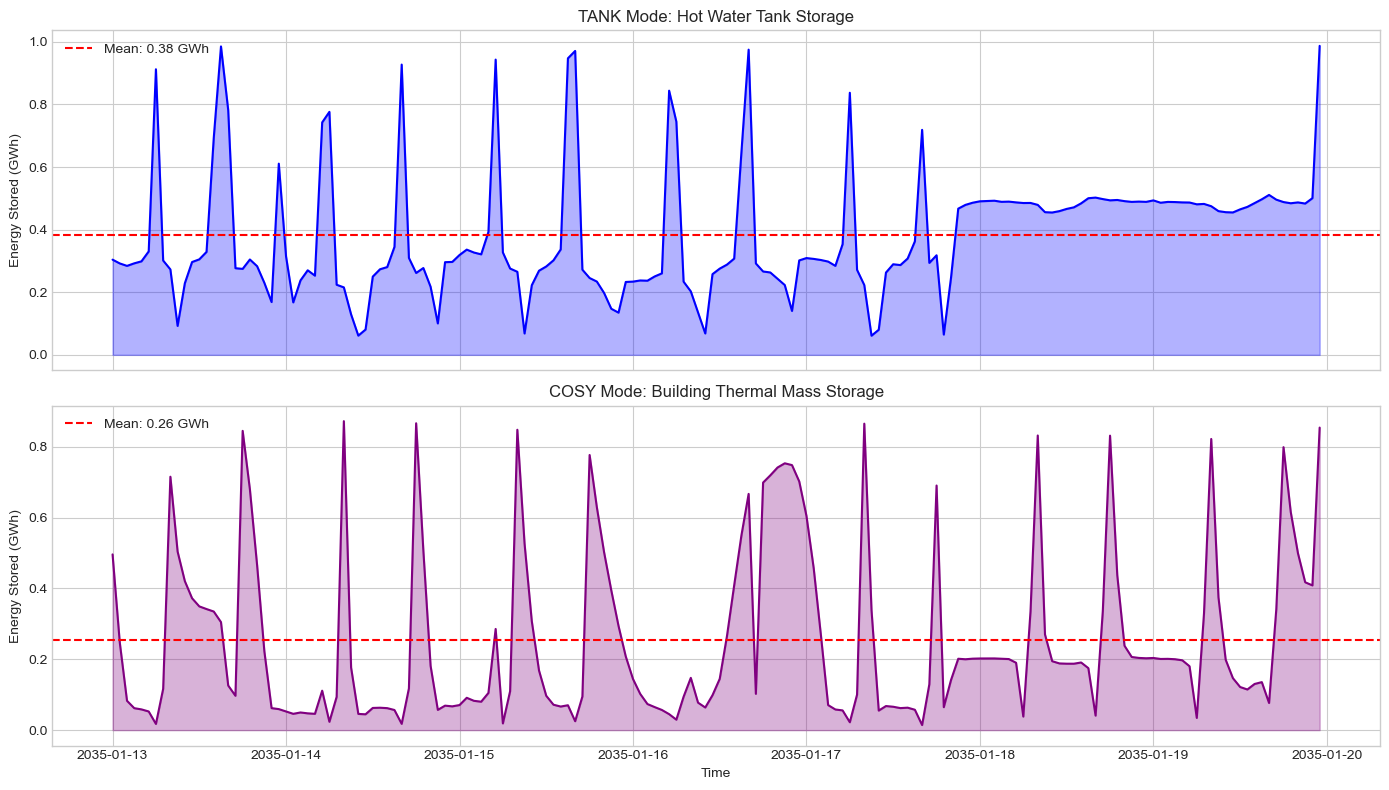

In [9]:
# Check store state of charge (energy stored over time)
if len(n.stores_t.e) > 0:
    tank_store_cols = [c for c in n.stores_t.e.columns if n.stores.loc[c, 'carrier'] == 'hot water']
    cosy_store_cols = [c for c in n.stores_t.e.columns if n.stores.loc[c, 'carrier'] == 'thermal inertia']
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    if tank_store_cols:
        tank_soc = n.stores_t.e[tank_store_cols].sum(axis=1) / 1000  # GWh
        axes[0].plot(tank_soc.index, tank_soc.values, linewidth=1.5, color='blue')
        axes[0].fill_between(tank_soc.index, tank_soc.values, alpha=0.3, color='blue')
        axes[0].set_ylabel('Energy Stored (GWh)')
        axes[0].set_title('TANK Mode: Hot Water Tank Storage')
        axes[0].axhline(y=tank_soc.mean(), color='red', linestyle='--',
                        label=f'Mean: {tank_soc.mean():.2f} GWh')
        axes[0].legend()
    
    if cosy_store_cols:
        cosy_soc = n.stores_t.e[cosy_store_cols].sum(axis=1) / 1000  # GWh
        axes[1].plot(cosy_soc.index, cosy_soc.values, linewidth=1.5, color='purple')
        axes[1].fill_between(cosy_soc.index, cosy_soc.values, alpha=0.3, color='purple')
        axes[1].set_ylabel('Energy Stored (GWh)')
        axes[1].set_title('COSY Mode: Building Thermal Mass Storage')
        axes[1].axhline(y=cosy_soc.mean(), color='red', linestyle='--',
                        label=f'Mean: {cosy_soc.mean():.2f} GWh')
        axes[1].legend()
    
    axes[1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()
else:
    print("No store time series data found - check if network was solved with store tracking")


### 6.3 Heat Demand vs Electricity Consumption

Thermal Demand: 718.9 GWh
Electrical Consumption: 550.1 GWh
Effective System COP: 1.32


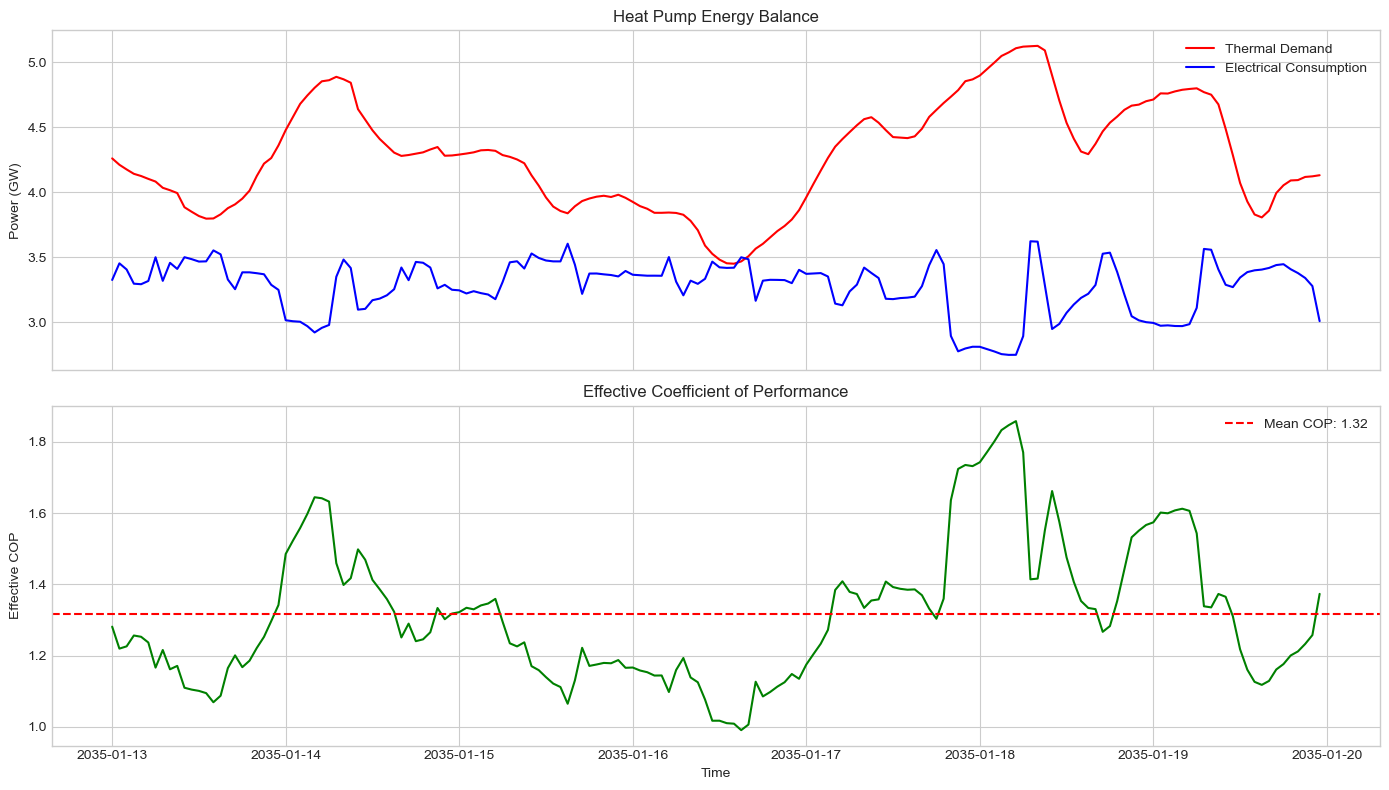

In [10]:
# Compare thermal demand with electrical consumption
# Thermal demand = heat delivered to space heating
# Electrical consumption = power drawn from grid
# Ratio should approximate mean COP

# Identify loads and links
tank_loads = n.loads[n.loads['carrier'] == 'hot water demand']
cosy_loads = n.loads[n.loads['carrier'] == 'space heating']
tank_hp_links = n.links[(n.links['carrier'] == 'heat pump') & (n.links.index.str.contains('tank'))]
cosy_thermal_links = n.links[n.links['carrier'] == 'thermal demand']

if len(n.loads_t.p_set) > 0 and (len(tank_hp_links) > 0 or len(cosy_thermal_links) > 0):
    # Get thermal demand from both TANK and COSY loads
    tank_load_cols = [c for c in n.loads_t.p_set.columns if c in tank_loads.index]
    cosy_load_cols = [c for c in n.loads_t.p_set.columns if c in cosy_loads.index]
    
    if tank_load_cols or cosy_load_cols:
        thermal_demand = n.loads_t.p_set[tank_load_cols + cosy_load_cols].sum(axis=1)
        
        # Get electrical consumption from HP links (TANK + COSY)
        tank_link_cols = [c for c in n.links_t.p0.columns if c in tank_hp_links.index]
        cosy_link_cols = [c for c in n.links_t.p0.columns if c in cosy_thermal_links.index]
        hp_link_cols = tank_link_cols + cosy_link_cols
        
        if hp_link_cols:
            elec_consumption = n.links_t.p0[hp_link_cols].sum(axis=1)
            
            # Calculate effective COP
            effective_cop = thermal_demand / elec_consumption.replace(0, np.nan)
            
            print(f"Thermal Demand: {thermal_demand.sum()/1000:.1f} GWh")
            print(f"Electrical Consumption: {elec_consumption.sum()/1000:.1f} GWh")
            print(f"Effective System COP: {effective_cop.mean():.2f}")
            
            # Plot comparison
            fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
            
            axes[0].plot(thermal_demand.index, thermal_demand.values / 1000, 
                        label='Thermal Demand', color='red', linewidth=1.5)
            axes[0].plot(elec_consumption.index, elec_consumption.values / 1000,
                        label='Electrical Consumption', color='blue', linewidth=1.5)
            axes[0].set_ylabel('Power (GW)')
            axes[0].set_title('Heat Pump Energy Balance')
            axes[0].legend()
            
            axes[1].plot(effective_cop.index, effective_cop.values, color='green', linewidth=1.5)
            axes[1].axhline(y=effective_cop.mean(), color='red', linestyle='--',
                           label=f'Mean COP: {effective_cop.mean():.2f}')
            axes[1].set_ylabel('Effective COP')
            axes[1].set_xlabel('Time')
            axes[1].set_title('Effective Coefficient of Performance')
            axes[1].legend()
            
            plt.tight_layout()
            plt.show()
        else:
            print("No heat pump links found")
    else:
        print("No thermal loads found")
else:
    print("Load or link time series not available")


## 7. Configuration Options

Heat pump flexibility is configured in `config/defaults.yaml`:

```yaml
heat_pumps:
  enabled: true
  flexibility:
    enabled: true
    tank_share: 0.5    # 50% of HP demand uses TANK mechanism
    cosy_share: 0.5    # 50% of HP demand uses COSY mechanism
    tank_storage_hours: 4.0  # Hours of storage at rated capacity
    cosy_storage_hours: 2.0  # Hours of thermal inertia
    tank_standing_loss: 0.01  # 1% per hour heat loss
    cosy_standing_loss: 0.05  # 5% per hour (less insulated)
```

### Key Parameters:

| Parameter | Description | Typical Value |
|-----------|-------------|---------------|
| `tank_share` | Fraction of HP demand with hot water tank flexibility | 0.3-0.5 |
| `cosy_share` | Fraction of HP demand with building thermal inertia | 0.3-0.5 |
| `tank_storage_hours` | Tank storage duration at rated power | 2-6 hours |
| `cosy_storage_hours` | Building thermal storage duration | 1-3 hours |
| `tank_standing_loss` | Hourly heat loss from tank | 0.5-3% |
| `cosy_standing_loss` | Hourly heat loss from building | 3-10% |

## 8. Summary

### Key Takeaways:

1. **Both TANK and COSY are space heating mechanisms** - they differ in where heat is stored:
   - TANK: Hot water cylinder (more storage, less loss)
   - COSY: Building fabric (less storage, more loss)

2. **COP is crucial** - Heat pumps produce 2-5x more thermal energy than electrical input
   - Higher COP in mild weather, lower in cold weather
   - Time-varying COP from weather data

3. **Flexibility helps the grid** by:
   - Shifting demand away from peak hours
   - Better utilizing renewable generation
   - Reducing need for expensive peaking plants

4. **PyPSA components**:
   - Links (heat pumps): Electricity → Thermal conversion at COP efficiency
   - Stores (tanks/buildings): Thermal energy storage
   - Loads (space heating): Final thermal demand